<a href="https://colab.research.google.com/github/awolaja/AI_in_Finance/blob/master/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install backtrader
!pip install alpaca-trade-api
!pip install yfinance
!pip install pandas_datareader

In [85]:
!pip install pandas==1.1.5 numpy==1.19.4 scipy==1.5.4

  Using cached pandas-1.1.5.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.19.4.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scipy-1.5.4.tar.gz (25.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [86]:
!pip3 install alpaca-trade-api

In [ ]:
# pip show alpaca-trade-api

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data as pdr
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.common import URL
import datetime as dt
import backtrader as bt
from alpaca_trade_api.rest import REST
import alpaca_trade_api as tradeapi

In [111]:
from datetime import datetime, timedelta
import pytz
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.common import URL

In [112]:
import alpaca_trade_api as tradeapi

In [113]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

In [114]:
# Define the p, d, q ranges to test
p = range(0, 6)
d = range(0, 2)
q = range(0, 6)
pdq_combinations = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

# Grid search over the pdq combinations
for pdq in pdq_combinations:
    try:
        model = ARIMA(df['close'], order=pdq)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = pdq
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA Model: {best_pdq} with AIC: {best_aic}")

Best ARIMA Model: None with AIC: inf


In [115]:
# Define your Alpaca API key and secret key
API_KEY = "PKB5WOUADWU7FATFGCYO"
API_SECRET = "s5SHSPqQ7NdZdS5xIGNrb1PeOeSY6MIJ6csRy9Fp"
BASE_URL = 'https://paper-api.alpaca.markets'
paper='true'

In [127]:
# Initialize Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

In [164]:
def get_historical_data(symbol, start_date, end_date, timeframe='1Day'):
    # Request historical data from Alpaca
    bars = api.get_bars(symbol, timeframe, start=start_date, end=end_date).df

    # Filter the DataFrame by date range
    bars = bars.loc[start_date:end_date]

    # Rename columns to make them more intuitive
    bars.reset_index(inplace=True)  # Convert 'timestamp' index to a column
    bars.rename(columns={'timestamp': 'time', 'open': 'open', 'high': 'high', 'low': 'low', 'close': 'close', 'volume': 'volume'}, inplace=True)

    # Ensure that the 'time' column is correctly formatted as a datetime
    bars['time'] = pd.to_datetime(bars['time'])
    bars.set_index('time', inplace=True)  # Set 'time' as the index

    return bars[['open', 'high', 'low', 'close', 'volume']]


In [146]:
# # Function to get historical data from Alpaca
# def get_historical_data(symbol, start_date, end_date, timeframe='1D'):
#     bars = api.get_bars(symbol, timeframe, start=start_date, end=end_date)
#     if isinstance(bars, list):
#         bars=bars[0]
#     else:
#       bars = bars[symbol]

#     data = []
#     for bar in bars:
#         data.append([bar.t, bar.o, bar.h, bar.l, bar.c, bar.v])

#     df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
#     df['time'] = pd.to_datetime(df['time'])
#     df.set_index('time', inplace=True)
#     return df


In [165]:
# Technical Indicators
def calculate_indicators(df):
    # Moving Averages
    df['SMA50'] = df['close'].rolling(window=50).mean()
    df['SMA200'] = df['close'].rolling(window=200).mean()

    # Bollinger Bands
    df['stddev'] = df['close'].rolling(window=20).std()
    df['UpperBB'] = df['SMA50'] + (df['stddev'] * 2)
    df['LowerBB'] = df['SMA50'] - (df['stddev'] * 2)

    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df

In [166]:
# ARIMA Forecasting
def arima_forecasting(df):
    model = ARIMA(df['close'], order=(5, 1, 0))  # Basic ARIMA model (5,1,0)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=5)  # Predict the next 5 periods
    return forecast

In [167]:
# Seasonality Detection
def seasonality_analysis(df):
    df['Month'] = df.index.month
    seasonality = df.groupby('Month')['close'].mean()
    return seasonality

In [168]:
# Backtesting Function
def backtest(df):
    cash = 100000  # Starting with $100,000
    position = 0  # No initial position
    initial_cash = cash
    returns = []

    for i in range(1, len(df)):
        # Buy Signal: When short-term SMA crosses above long-term SMA
        if df['SMA50'][i] > df['SMA200'][i] and df['SMA50'][i-1] <= df['SMA200'][i-1]:
            if position == 0:  # Buy
                position = cash / df['close'][i]
                cash = 0
                print(f"Buy at {df.index[i]} price {df['close'][i]}")

        # Sell Signal: When short-term SMA crosses below long-term SMA
        elif df['SMA50'][i] < df['SMA200'][i] and df['SMA50'][i-1] >= df['SMA200'][i-1]:
            if position > 0:  # Sell
                cash = position * df['close'][i]
                position = 0
                print(f"Sell at {df.index[i]} price {df['close'][i]}")

        # Calculate portfolio value and store returns
        portfolio_value = cash + position * df['close'][i]
        returns.append(portfolio_value)

    total_return = (cash + position * df['close'][-1] - initial_cash) / initial_cash
    print(f"Total Return: {total_return * 100:.2f}%")

    return returns

In [169]:
# Profitability Assessment: Sharpe Ratio and Max Drawdown
def calculate_profitability(returns):
    returns = pd.Series(returns)
    risk_free_rate = 0.01  # Example of a risk-free rate (1%)
    sharpe_ratio = (returns.pct_change().mean() - risk_free_rate) / returns.pct_change().std()
    max_drawdown = (returns / returns.cummax() - 1).min()
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

In [170]:
# Plotting Function
def plot_indicators(df):
    plt.figure(figsize=(12, 8))

    # Plot Closing Price and Moving Averages
    plt.plot(df['close'], label='Close Price')
    plt.plot(df['SMA50'], label='SMA 50', linestyle='--')
    plt.plot(df['SMA200'], label='SMA 200', linestyle='--')

    # Plot Bollinger Bands
    plt.fill_between(df.index, df['UpperBB'], df['LowerBB'], color='gray', alpha=0.2, label='Bollinger Bands')

    # Plot Buy/Sell Signals
    buy_signals = df[(df['SMA50'] > df['SMA200']) & (df['SMA50'].shift(1) <= df['SMA200'].shift(1))]
    sell_signals = df[(df['SMA50'] < df['SMA200']) & (df['SMA50'].shift(1) >= df['SMA200'].shift(1))]

    plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', s=100)

    plt.title('Technical Indicators and Trading Signals')
    plt.legend()
    plt.show()

In [171]:
# Example usage
symbol = 'SPY'  # S&P 500 ETF
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

Total Return: 0.00%


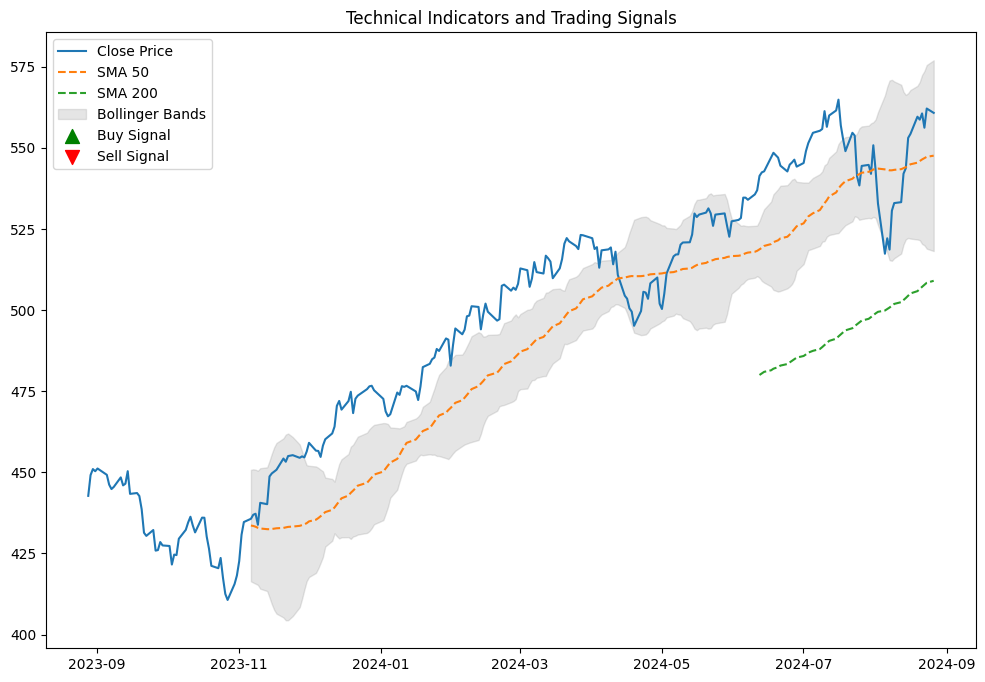

Sharpe Ratio: -inf
Maximum Drawdown: 0.00%
ARIMA Forecast: 251    560.922836
252    560.152450
253    561.263186
254    560.704281
255    560.768763
Name: predicted_mean, dtype: float64
Seasonality Analysis:
Month
1     478.810952
2     499.971500
3     515.735000
4     509.577273
5     522.420455
6     540.500000
7     552.018182
8     526.160455
9     439.932500
10    425.657273
11    445.253333
12    467.454500
Name: close, dtype: float64


In [172]:
df = get_historical_data(symbol, start_date, end_date)
df = calculate_indicators(df)
forecast = arima_forecasting(df)
seasonality = seasonality_analysis(df)
returns = backtest(df)
plot_indicators(df)
calculate_profitability(returns)

# Display ARIMA Forecast
print(f"ARIMA Forecast: {forecast}")

# Display Seasonality Analysis
print(f"Seasonality Analysis:\n{seasonality}")

In [ ]:
class OptionPricing:
    def __init__(self, S0, E, T, rf, sigma, iterations):
        """
        Initialize the OptionPricing class with given parameters.

        Parameters:
        S0 (float): Current stock price
        E (float): Strike price
        T (float): Time to maturity (in years)
        rf (float): Risk-free interest rate
        sigma (float): Volatility of the stock
        iterations (int): Number of simulation iterations
        """
        self.S0 = S0
        self.E = E
        self.T = T
        self.rf = rf
        self.sigma = sigma
        self.iterations = iterations

In [ ]:
    def call_option_simulation(self):
        """
        Simulate the pricing of a call option using Monte Carlo simulation.

        Returns:
        float: Present value of the average payoff for the call option
        """
        # Generate random normal numbers
        rand = np.random.normal(0, 1, self.iterations)

        # Simulate stock prices at maturity
        stock_price = self.S0 * np.exp(self.T * (self.rf - 0.5 * self.sigma**2) + self.sigma * np.sqrt(self.T) * rand)

        # Calculate the payoff for the call option
        payoff = np.maximum(stock_price - self.E, 0)

        # Calculate the average payoff
        average_payoff = np.mean(payoff) * np.exp(-self.rf * self.T)

        # Discount the average payoff to present value
        return np.exp(-self.rf * self.T) * average_payoff

In [ ]:
    # def put_option_simulation(self):
    #     """
    #     Simulate the pricing of a put option using Monte Carlo simulation.

    #     Returns:
    #     float: Present value of the average payoff for the put option
    #     """
    #     # Generate random normal numbers
    #     rand = np.random.normal(0, 1, self.iterations)

    #     # Simulate stock prices at maturity
    #     stock_price = self.S0 * np.exp(self.T * (self.rf - 0.5 * self.sigma**2) + self.sigma * np.sqrt(self.T) * rand)

    #     # Calculate the payoff for the put option
    #     payoff = np.maximum(self.E - stock_price, 0)

    #     # Calculate the average payoff
    #     average_payoff = np.mean(payoff)

    #     # Discount the average payoff to present value
    #     return np.exp(-self.rf * self.T) * average_payoff


In [ ]:
def put_option_simulation(self):
        rand = np.random.normal(0, 1, self.iterations)
        stock_price = self.S0 * np.exp(self.T * (self.rf - 0.5 * self.sigma**2) + self.sigma * np.sqrt(self.T) * rand)
        payoff = np.maximum(self.E - stock_price, 0)
        average_payoff = np.mean(payoff)
        return np.exp(-self.rf * self.T) * average_payoff

In [ ]:
def get_option_data(api, symbol):
    try:
        # Fetch the current stock price
        bars = api.get_bars(symbol, tradeapi.TimeFrame.Day, "2024-07-01", "2024-07-24").df
        stock_price = bars['close'].iloc[-1]

        # Fetch the option data
        option_chain = api.get_option_chain(symbol=symbol)
        contracts = option_chain.contracts
        expirations = list(contracts.keys())
        implied_volatility = contracts[expirations[0]][0].implied_volatility

        return stock_price, implied_volatility
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

In [ ]:
if __name__ == '__main__':
    API_KEY = 'api_key'
    SECRET_KEY = 'api_secret'
    BASE_URL = 'https://paper-api.alpaca.markets'

    alpaca_api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

    symbol = 'AAPL'
    stock_price, implied_volatility = get_option_data(alpaca_api, symbol)

    if stock_price is not None and implied_volatility is not None:
        # Set the parameters for the simulation
        E = 160  # Example strike price
        T = 0.5  # Example time to maturity in years
        rf = 0.01  # Example risk-free interest rate
        iterations = 100000

        option_pricing = OptionPricing(stock_price, E, T, rf, implied_volatility, iterations)
        call_price = option_pricing.call_option_simulation()
        put_price = option_pricing.put_option_simulation()

        print(f"Call Option Price: {call_price}")
        print(f"Put Option Price: {put_price}")
    else:
        print("Failed to fetch option data.")